# The size and frequency of waves by novel variants

Since late 2020, the dynamics of SARS-CoV-2 incidence is driven by the emergence of novel variants that are either more transmissible than competing variants, or have changed in such a way that they can (partially) evade population immunity.  Immune evasive variants can spread faster due to a larger pool of susceptible hosts. 
The spread of such contagious diseases and the competition between variants is typically modeled by Susceptile-Infected-Recovered (SIR) models. 
These SIR models come in many flavors, but even more complex versions are rather crude approximations of the spread of a diverse virus in a population that is heterogenous in many aspects, including immunological, demographic, mobility, contact patters, etc. 
As a result these models are not very useful for quantitative predictions and inference, but they can inform intuition and illuminate how observed patterns depend on phenomenological parameters that capture general aspects of spread. 
The latter is the objective of this note and it is mostly reiterating well known material from textbooks.
In particular, I will discuss how

 * the final epidemic size in absence of waning depends on parameters
 * the fixed point, frequency of waves, and dampening of oscillations with waning
 * the size of variant waves and how they depend on population heterogeneity
 
I will close with some thoughts on how to incorporate gradual waning of immunity in the population, for example via gradually decreasing neutralization titers, into SIR models. Waves generated by immune evasive in these models fall between the extreme cases expected from simple SIR models without population heterogeneity. 

## Basic SIR model with waning

The basic SIR model is
$$
\begin{split}
\dot{S} & = -\beta I S + \gamma (1-S) \\
\dot{I} & = \beta I S - \nu I
\end{split}
$$

where $\nu$ is the recovery rate of an infected individual. We will use this rate to set the unit of time, that is we measure time in units of pathogen generations and set to $\nu=1$. 
For diseases of interest here, $\nu \approx 1/\mathrm{week}$ or $2/\mathrm{week}$ such that there are 50 to 100 generations per year.
The parameters $\beta$ and $\gamma$ are the rate at which the disease spreads from infected to susceptible individuals and the rate at which recovered indivuals loose their immunity and become susceptible again, respectively.
The latter plays the same role as the population turn-over rate and we will lump the two together (population turn-over is much slower than waning). 
The *basic reproductive* number is given by $R_0 = \beta/\nu$, while the initial growth rate of an outbreak in c completely susceptible population is given by $\beta - \nu$.  We ignore population turn-over in this note.

The behavior of this model with and without waning ($\gamma=0$ or $>0$) is shown below. 

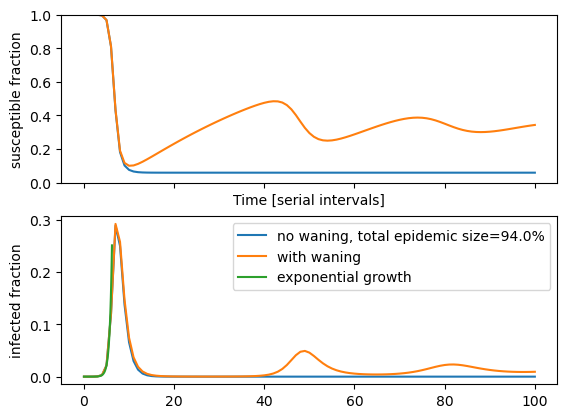

In [12]:
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt

def SIR(y, t, beta, gamma):
    S,I = y
    dS = -beta*I*S + gamma*(1-S)
    dI = beta*I*S - I
    return (dS, dI)

I0 = 1e-6
beta = 3
gamma = 1/50

T = np.linspace(0,100,101)
Tlinear = np.linspace(0,-0.9*np.log(I0)/(beta-1),101)
sol_nowaning = odeint(SIR, (1-I0, I0), T, args=(beta, 0))
sol_waning = odeint(SIR, (1-I0, I0), T, args=(beta, gamma))

fig, axs = plt.subplots(2,1, sharex=True)
axs[0].plot(T, sol_nowaning[:,0], label = 'no waning')
axs[1].plot(T, sol_nowaning[:,1], label = f'no waning, total epidemic size={100-sol_nowaning[-1,0]*100:1.1f}%')
axs[0].plot(T, sol_waning[:,0], label = 'with waning')
axs[1].plot(T, sol_waning[:,1], label = 'with waning')
axs[1].plot(Tlinear, I0*np.exp((beta-1)*Tlinear), label = 'exponential growth')
axs[0].set_ylim(0,1)
axs[0].set_ylabel('susceptible fraction')
axs[1].set_ylabel('infected fraction')
axs[1].legend()
axs[0].set_xlabel('Time [serial intervals]');

As expected, the numerica solution above show that the initial dynamics do not depend on $\gamma$. 
This holds as long as waning is slow compared to the duration of the first wave. 
After the initial peak, the solution with waning exhibits a damped oscillation around a fixed point. 
Without waning, the pool of susceptibles is irreversibly reduced and so small that it does not support pathogen spread. The system hence settles to a disease free state $I(t)=0$ with 94% of the population immune (in the above example). Both the final epidemic size in absense of waning and the equilibrium properties can be explored analytically. 

## Final epidemic size
Without waning, the residual susceptibility is simply the fraction of people that didn't get infected during the wave. To solve for the final size ([See here for a detailed discussion](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3506030/)) for $\gamma=0$, one divides $\dot{I}$ by $\dot{S}$ to obtain
$$
\frac{dI}{dS} = -1 + \frac{1}{\beta S}
$$
which can be integrated
$$
I(t) - I(0) = S(0) - S(t)  + \frac{\log(S(0)/S(t))}{\beta}
$$
For $t\to \infty$, $I(t) \to 0$ and $I(0)$ can be chosen infinestimally small such that the final susceptibility is the solution of this transzental equation:
$$
S(t_\infty) = S(0)e^{-\beta (S(0) - S(t_\infty))}
$$

For large $\beta$ and an initially completely susceptible population $S(0)=1$, $S(\infty)\approx e^{-\beta}$. 
For $\beta$ close to 1 we can expand the exponential and solve for $R(t_\infty) = 1-S(t_\infty)$  
$$
\begin{split}
R(t_\infty) & = 1 - e^{-\beta R(t_\infty)} \approx  \beta R(t_\infty) - \frac{\beta^2 R(t_\infty)^2}{2}  + \cdots
\end{split}
$$
This linear approximation yields $R(t_\infty) \approx 2(\beta-1)$ confirming the notion that a similar of people are infected before and after the peak of the wave. The full equation can be solved iteratively.

In [13]:
beta = 1.4
def final_epidemic_size(beta, max_iter=None, S0=1):
    if max_iter is None: max_iter = 10 + int(10/(beta-1))
    Sf = 0.5*S0
    for i in range(max_iter):
        Sf = S0*np.exp(-beta*(S0-Sf))

    return 1-Sf
        
beta = 3
print(f"final size for {beta=} is: {final_epidemic_size(beta, S0=1.0):1.3f}")

final size for beta=3 is: 0.940


## Equilibrium with waning

With positive $\gamma$, there is a non-trival fix point at
$$
\bar{S} = \beta^{-1} \quad \mathrm{and} \quad \bar{I} = \gamma(1-\beta^{-1}) =  \gamma(1-\bar{S})
$$
This fixed point has the intuitive property that $R_e = \beta\bar{S} = 1$ and that the average incidence is rate at which immune individuals become susceptible (the product of the rate of waning and the size of the immune compartment $1-\bar{S}$). 
Deviation $\delta S$ and $\delta I$ from this steady state ($\bar{S}, \bar{I}$) can be analyzed by linear perturbation theory. 
<!--
$$
\begin{split}
\dot{\delta S} & \approx -\beta (\bar{S} + \delta S)(\bar{I} + \delta I)  + \gamma (1- \bar{S} - \delta S)  
%\\ & = -\beta (\bar{S}\delta I + \bar{I}\delta S) - \gamma \delta S = -\beta \delta I  - \gamma(\beta -1 ) \delta S - \gamma \delta S
=  - \delta I -\gamma \beta \delta S \\
\dot{\delta I} & \approx \beta  (\bar{I}+\delta I)(
\bar{S} + \delta S)- \bar{I} - \delta I 
%\\ & =  \beta\bar{I}\delta S + \beta\bar{S}\delta I - \delta I 
= \gamma(\beta -1 )\delta S
= \gamma (\beta -1) \delta S
\end{split}
$$
-->
In matrix form, the linearized system is given by
$$
\left(
\begin{matrix}
\dot{\delta S}\\
\dot{\delta I}
\end{matrix}\right) = 
\left(
\begin{matrix}
-\gamma \beta & -1\\
\gamma (\beta-1) & 0
\end{matrix}\right)
\left(
\begin{matrix}
\delta S\\
\delta I
\end{matrix}\right)
$$
with characteristic equation $-\lambda(\gamma\beta - \lambda) + \gamma (\beta-1)=0$ and eigenvalues
$$
\lambda_{1/2} = -\frac{\gamma \beta}{2} \pm \sqrt{\gamma^2 \beta^2/4 - \gamma(\beta -1)}
$$
The corresponding right-eigenvectors are 
$$
v_{1/2} = \left(\begin{matrix} -1 \\ \lambda_{1/2} + \gamma \beta  \end{matrix}\right)
$$
When $\gamma < \frac{4}{\beta(1- \beta)}$, as is true in cases of interest, the system exhibits dampened oscillations with a frequency
$$
\omega = \sqrt{\gamma(\beta -1) - \gamma^2 \beta^2/4} \approx \sqrt{\gamma(\beta-1)}\left(1 - \frac{\gamma\beta^2}{8(\beta-1)}+\ldots \right)
$$
and a decay time $\tau = \frac{2}{\gamma\beta}$.

A period $T$ is thus related to $\gamma$ and $\beta$ via $2\pi = \omega T \approx \sqrt{\gamma(\beta-1)}T$.
With $\beta$ somewhere around 5, waves every 4 months (20-25 serial intervals) imply a rate of waning of 
$\gamma = \frac{4\pi^2}{4\cdot{} 25^2}\approx \frac{1}{60}$ per serial interval.
Note that this rate of waning includes contributions from viral evolution, which will be discontinuous jumps associated with the emergence of novel variants, and individual loss of immunity which will be gradual at the population level.

### Linear solution around the fixed point
To calculate the coefficients of the linear solution with the above eigenvalues and eigenvectors, we need the left eigenvectors
$$
u_{1/2} = \frac{1}{\gamma (\beta-1)}\left(\begin{matrix} \gamma (\beta-1) \\ \lambda_{1/2} + \gamma \beta  \end{matrix}\right)
$$
which scaled such that $v_i \cdot u_i = 1$. Coefficients of the solution
$$
\left(
\begin{matrix}
S\\
I
\end{matrix}\right) = 
\left(
\begin{matrix}
\bar{S}\\
\bar{I}
\end{matrix}\right) +  
e^{-t/\tau} \left(a_1 e^{i\omega t} + a_2 e^{-i \omega t}\right)
$$
where $a_i = u_i \left(
\delta S(0), 
\delta I(0)
\right)^t
$



In [14]:
def linear_approximation(S0, I0, T, beta, gamma):
    Seq = 1/beta
    Ieq = gamma*(1-1/beta)
    dS=S0-Seq
    dI=I0-Ieq

    omega = np.sqrt(gamma*(beta-1) - gamma**2*beta**2/4)
    tau = 2/gamma/beta
    v1 = [-1, -1/tau + omega*1j + gamma*beta]
    v2 = [-1, -1/tau - omega*1j+ gamma*beta]
    u1 = [1, (-1/tau+omega*1j + gamma*beta)/gamma/(beta-1)]
    u2 = [1, (-1/tau-omega*1j + gamma*beta)/gamma/(beta-1)]
    a1 = np.dot(u1, [dS, dI])/np.dot(u1, v1)
    a2 = np.dot(u2, [dS, dI])/np.dot(u2, v2)

    return {'Seq':Seq, 'Ieq': Ieq, 
            'S': Seq + np.exp(-T/tau)*np.real(
                                    a1*(np.cos(omega*T) + np.sin(omega*T)*1.0j)*v1[0] + 
                                    a2*(np.cos(omega*T) - np.sin(omega*T)*1.0j)*v2[0]),
            'I': Ieq + np.exp(-T/tau)*np.real(
                                    a1*(np.cos(omega*T)+np.sin(omega*T)*1.0j)*v1[1] + 
                                    a2*(np.cos(omega*T)-np.sin(omega*T)*1.0j)*v2[1])}


beta = 3
gamma = 1/50
T = np.linspace(0,200,101)
S0 = 1/beta + 0.05
I0 = gamma*(1-1/beta)
sol_waning = odeint(SIR, (S0, I0), T, args=(beta, gamma))
res = linear_approximation(S0, I0, T, beta, gamma)


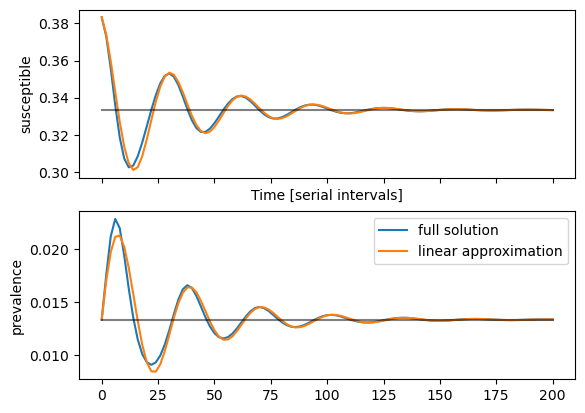

In [15]:
fig, axs = plt.subplots(2,1, sharex=True)

axs[0].plot(T, sol_waning[:,0], label = 'with waning')
axs[0].plot(T, res['S'], label = 'linear approximation')
axs[0].plot(T, np.ones_like(T)*res['Seq'], c='k', alpha=0.5)
axs[1].plot(T, sol_waning[:,1], label = 'full solution')
axs[1].plot(T, res['I'], label = 'linear approximation')
axs[1].plot(T, np.ones_like(T)*res['Ieq'], c='k', alpha=0.5)
axs[0].set_ylabel('susceptible')
axs[1].set_ylabel('prevalence')
axs[1].legend()
axs[0].set_xlabel('Time [serial intervals]');

## Size of waves caused by invading variants

After having explored the size of an initial outbreak and the equilibrium in a population where immunity wanes, let's consider a new, initially rare, variant that grows at a rate $\alpha$ in a population where the resident variant is at equilibrium.
This growth rate is related to $\beta^*$ and the susceptibility $S^*$ of the new variant via $\alpha = \beta^* S^* - 1$.

Within this simple model, a novel variant could grow with rate $\alpha$ for different reasons

 * The variant is more transmissible with increased $\beta^*$ but unchanged $S^*=S$, no immune evasion. In this case $\beta^* = \frac{1+\alpha}{S} = (1 + \alpha)\beta$. 
 * The variant grows because a fraction of the population is completely susceptible again but $\beta^*=\beta$ is unchanged. In this case, the new susceptibility is $S^* = S (1+\alpha)$. 
 * The variant grows because immune protection of the entire population is reduced. This would correspond to a model with $S^* = 1$ and $\beta^* = 1+\alpha$. 

These three scenarios (mixtures of them are of course possible) lead to waves of rather different size. Since we are concerned with the wave caused by a single invading variant, we can ignore waning and set $\gamma=0$. Despite identical initial growth rates, the size of the wave is much higher when transmission is supported by slow spread in the entire population compared to fast spread limited by immunity in most of the population. When significant waning occurs over the course of the wave caused by the new variant, the epidemic sizes of the different scenarios become more similar.


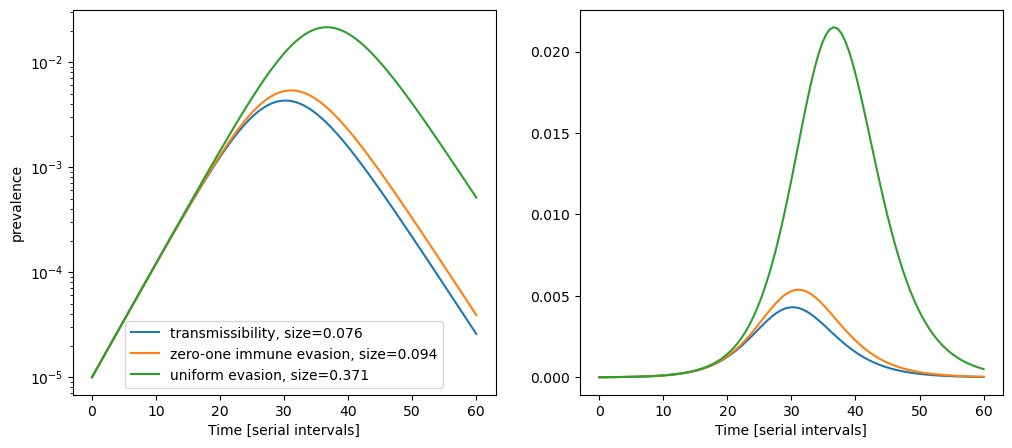

In [61]:
beta = 5
gamma =0/50

T = np.linspace(0,60,101)
S0 = 1/beta
I0 = gamma*(1-1/beta)

alpha = 0.25 # growth per nu
I1 = 1e-5 # new variant
sol_transmission = odeint(SIR, (S0, I1), T, args=(beta*(1+alpha), gamma))
sol_zeroOneEvasion = odeint(SIR, (S0*(1+alpha), I1), T, args=(beta, gamma))
sol_uniformEvasion = odeint(SIR, (1-I1, I1), T, args=((1+alpha), gamma))

fig, axs = plt.subplots(1,2, figsize = (12,5))
for ax in axs:
    ax.plot(T, sol_transmission[:,1], 
         label=f'transmissibility, size={S0-1+final_epidemic_size(beta*(1+alpha), S0=S0):1.3f}')
    ax.plot(T, sol_zeroOneEvasion[:,1],  
         label=f'zero-one immune evasion, size={S0*(1+alpha)-1+final_epidemic_size(beta, S0=S0*(1+alpha)):1.3f}')
    ax.plot(T, sol_uniformEvasion[:,1],  
         label=f'uniform evasion, size={final_epidemic_size((1+alpha), S0=1):1.3f}')
axs[0].legend()
axs[0].set_yscale('log')
axs[0].set_xlabel('Time [serial intervals]')
axs[1].set_xlabel('Time [serial intervals]')
axs[0].set_ylabel('prevalence');

Over the past 18 months, we have frequently seen variants with doubling times between one and two weeks, corresponding to growth rates between 0.2 and 0.5 per serial interval. 

## Incorporating heterogeneous population immunity in SIR models. 

The models above classify individuals as either completely susceptible or completely protected with transitions between these "compartements". 
More generally, different individuals differ in their response to the virus and have been exposed to different variants at different times in the past with gradual waning of immunity. 
We therefore expect there to be a distribution of protective immunity in the population.
Related extensions of SIR models have been proposed by [Mohamed El Khalifi and Tom Britton](https://arxiv.org/abs/2211.09062).

A simple model of the probability of infection upon exposure could be
$$
p = e^{-x}
$$
where $x$ could be interpreted as a neutralization titer or some other correlate of protection. In the population, there is a distribution $\phi(x,t)$ that is governed by waning with rate $v$, boosting by infection with rate $\nu I(t)$:
$$
\frac{\partial \phi}{\partial t} = D \frac{\partial^2 \phi(x,t)}{\partial^2 x} + v\frac{\partial \phi(x,t)}{\partial x} + I(t) \left(\delta(x-x_0) - \beta \phi(x,t) e^{-x}\right)
$$
The first diffusive term accounts for variation in the waning rate $v$ and boosting through cross-immunity with other pathogens. 

The infection dynamics is given by 
$$
\frac{dI}{dt} = I(t) \left(\beta \int_0^\infty dx \phi(x,t) e^{-x} - 1\right)
$$

As before, we use the recovery rate to set the unit of time. 
Other scales and numbers that play a role are:

 * $\beta$ is the infectivity and related to $R_0$ via $R_0 = \frac{\beta}{\nu}$
 * $v$ is the velocity at which titers drop. We generally expect this to be on the order of 0.01 to 0.1/per week corresponding to 0.5 to 5 antigenic units per year. 
 * $x_0$ is the typical post-infection titer.
 * $D$ the titer diffusivity. This diffusivity will capture heterogeneity in the rate of titer drops and other variation. I don't have an expectation for its value. But I imagine something like $0.02$ per serial interval is sensible, resulting in an 2 unit^2 variance after a year.

The average susceptibility in this model is then given by 
$$
\langle S \rangle = \int_0^{x_0} dx\, \phi(x) e^{-x}
$$
And the resulting growth rate of the outbreak is 
$$
\beta \langle S \rangle - 1 = \beta \int_0^{x_0} dx\, \phi(x) e^{-x} - 1
$$



At first, this model exhibits narrow waves with increasing frequency before settling into a pattern of damped oscillations similar to the compartmental model above.

* Initially, the is no population heterogeneity and the time between waves is given by the time it takes for population to loose immunity from $x=x_0$ to $x<1$, which is $t=x_0/v$. Since the gradual transmission from an immune state to a susceptible state takes time, this model effectively implements a delay which could give rise to sustained oscillations. For parameter values investigate here, oscillations are damped. 
* Once the population distribution of $x$ has equilibrated, the system has a tendency to oscillate around a fixed point similar to the SIR model. But these oscillations decay less rapidly than in the equivalent SIR model with $\gamma=v/x_0$, which would correspond to the inverse of the time over which people loose their immunity. The period of the oscillations is also longer than the $t = 2\pi/\sqrt{(\beta-1)\gamma}$ expected in the compartmental model. 


In [21]:
def SusceptI(Y, t, beta, gamma, D, v, xgrid, dx):
    '''
    time derivative of the prevalence and the susceptibility distribution.
    '''
    # convert D and v to right/left jump rates. stuff all waning into the left jumps
    r = D/2/dx**2  #+ v/2/dx
    l = D/2/dx**2 + v/dx

    I, phi = Y[0], Y[1:]
    dY = np.zeros_like(Y)
    dY[0] = I*(beta*dx*np.sum(phi*np.exp(-xgrid))-1)
    dY[1] = -(r + gamma + beta*I*np.exp(-xgrid[0]))*phi[0] + gamma/dx + l*phi[1]
    dY[-1] =  -(l + gamma + beta*I*np.exp(-xgrid[-1]))*phi[-1] + I/dx + r*phi[-2]
    dY[2:-1] = - (r + l + gamma + beta*I*np.exp(-xgrid[1:-1]))*phi[1:-1] + r*phi[0:-2] + l*phi[2:]
    
    return dY

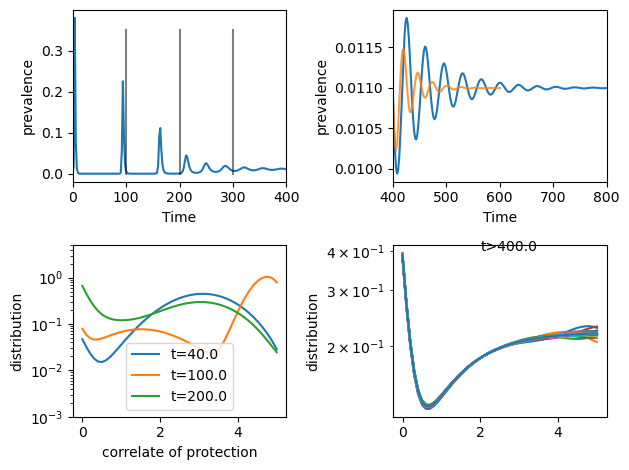

In [22]:
beta = 5 # if nu is 1, this is R0
gamma = 0.0/50/3000 # population turnover rate

D = 0.02 # titer unit^2/(1/nu)
v = 0.05 # titer units/(1/nu)  # waning. multiply by 50-100 to get the waning per year (assuming 50-100 generation per year)

x0 = 5
xgrid = np.linspace(0,x0,51)
dx = xgrid[1]

phi = np.zeros_like(xgrid)
phi[0] = 1/dx  # normalized delta-like function at x=0 == naive
I = 0.00001
Y = np.array([I] + list(phi))

T = np.linspace(0,800,401)

sol = odeint(SusceptI, Y, T, (beta, gamma, D, v, xgrid, dx))

fig, axs = plt.subplots(2,2,sharex=False)
ti_start = 200

axs[0,0].plot(T, sol[:,0], label='prevalence')
axs[0,0].set_xlim(0, T[ti_start])
for i in [1,2,3]:
    axs[0,0].plot([i*x0/v, i*x0/v], [0,0.35], c='k', alpha=0.5)

Tlin = np.linspace(0,200,101)
res_lin = linear_approximation(dx*np.sum(sol[ti_start,1:]*np.exp(-xgrid)), sol[ti_start,0], 
                               Tlin, beta, sol[-1,0]/(1-1/beta))

axs[0, 1].plot(T[ti_start:], sol[ti_start:,0], label='prevalence')
axs[0, 1].plot(T[ti_start]+Tlin, res_lin['I'], c='C1', alpha=0.8)
axs[0, 1].set_xlim(T[ti_start], T[-1])
axs[0, 0].set_ylabel('prevalence')
axs[0, 0].set_xlabel('Time')
axs[0, 1].set_ylabel('prevalence')
axs[0, 1].set_xlabel('Time')

for ti in range(len(T)//2, len(T), 5):
    axs[1,1].plot(xgrid, sol[ti,1:])
axs[1,1].text(2,0.4, f"t>{T[len(T)//2]}")

for ti in [20, 50, 100]:
    axs[1,0].plot(xgrid, sol[ti,1:], label=f't={T[ti]:1.1f}')

axs[1, 0].legend(loc=8)
axs[1, 1].set_yscale('log')
axs[1, 0].set_yscale('log')
axs[1, 0].set_ylim(1e-3,5)
axs[1, 0].set_ylabel('distribution')
axs[1, 1].set_ylabel('distribution')
axs[1, 0].set_xlabel('correlate of protection');
plt.tight_layout()

This pattern of accellerating waves that gradually dampen is also observed in COVID-19, for example in the hospitalization data of the UK:

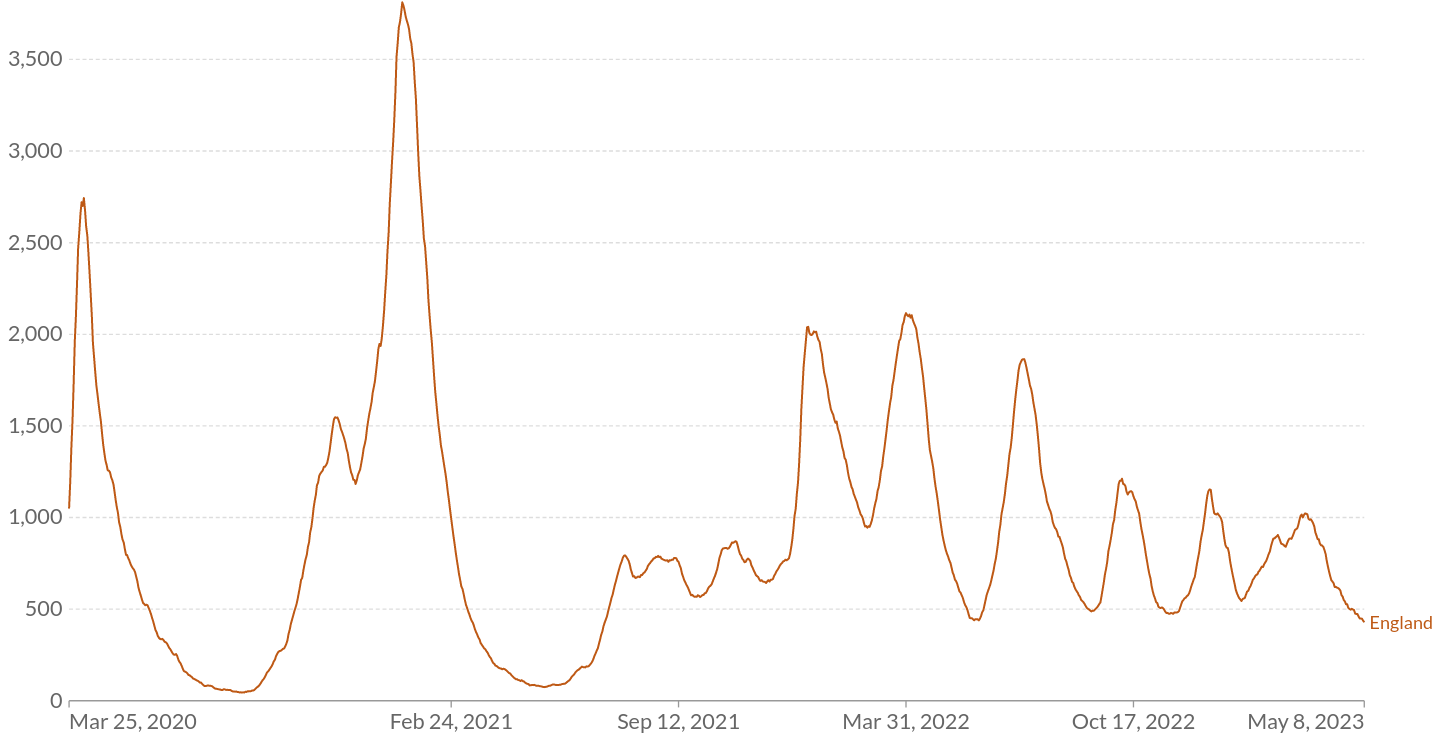
Figure: Hospitalization data from England vizualized by [OurWorldInData](https://ourworldindata.org/grapher/uk-daily-covid-admissions?country=London~South+East~England). 

However, the first two peaks here correspond to initial wave and the Alpha wave and their timing is not determined by immune waning dynamics but the emergence of variants. Since late 2021, the more or less continuous circulation of Omicron variants with a 3-4 months period is more suggestive of a dynamics determined by immune waning and reinfection. 



## Immune evasive variants

Now consider an immune evasive variant invading. The susceptibility of the population to this variant can differ from that of the original variant in different ways. 

 * the titers in the population could be uniformly reduced by a factor, that is $x \rightarrow \max(0, x-\delta x)$ and $\phi'(x) = \phi(x-\delta x)$ for $x> 0$ and $\phi'(0) = \int_0^{\delta x} dx \phi(x)$. We'll refer to this case as __shifted__ susceptibility.
 * a fraction $\epsilon$ of the population becomes completely susceptible, i.e. $\phi'(0) = \phi(0) + \epsilon$ and $\phi'(x) = (1-\epsilon)\phi(x)$. We'll refer to this case as __partial loss__.
 
With increasing number of variants, susceptibilities and cross-immunities, model become a lot more complex. But we will consider a simple case where we only consider the immune escape variant with the modified susceptibility $\phi(x)$ and ingore the resident. In this case, we still have a single variant model with the same parameters. The variant initially grows with a rate $\beta \langle S \rangle$.

To compare how the size of a wave depends on the model assumptions, we numerically solve for a wave with an initial susceptibility $\phi$ according the __shift__ and __partial loss__ models and compare this to the waves in standard SIR models. For the latter, we assume that (i) every body in the population is partially susceptible (uniform evasion), that that a fraction of the population is fully susceptible and the remainder fully immune (zero/one). In all cases, parameters are adjusted such that the initial growth rates are equal:
 

In [65]:
# copy the equilibrium susceptibility distribution
phi_base_line = np.copy(sol[-1,1:])

# calculate the shifted probability distribution
delta_x = 1
phi_shift = np.zeros_like(phi_base_line)
phi_shift[:(xgrid>delta_x).sum()] = phi_base_line[xgrid>delta_x]
phi_shift[0] += phi_shift[xgrid<=delta_x].sum()
S_avg_shift = np.sum(np.exp(-xgrid)*phi_shift)*dx

# calculate the probability for the partial_loss case
eps = 0.21
phi_loss = phi_base_line*(1-eps)
phi_loss[0] += phi_base_line.sum()*eps
S_avg_loss = np.sum(np.exp(-xgrid)*phi_loss)*dx

growth_rate = beta*S_avg_shift-1
print(f"average susceptibility -- shift:{S_avg_shift:1.3f}, loss:{S_avg_loss:1.3f}")
print(f"growth rate: {growth_rate:1.3f}")
I = 0.001
T = np.linspace(0,30,31)
Y = np.array([I] + list(phi_shift))
sol_shift = odeint(SusceptI, Y, T, (beta, gamma, D, v, xgrid, dx))
Y = np.array([I] + list(phi_loss))
sol_loss = odeint(SusceptI, Y, T, (beta, gamma, D, v, xgrid, dx))


average susceptibility -- shift:0.365, loss:0.366
growth rate: 0.823


Text(0, 0.5, 'prevalence')

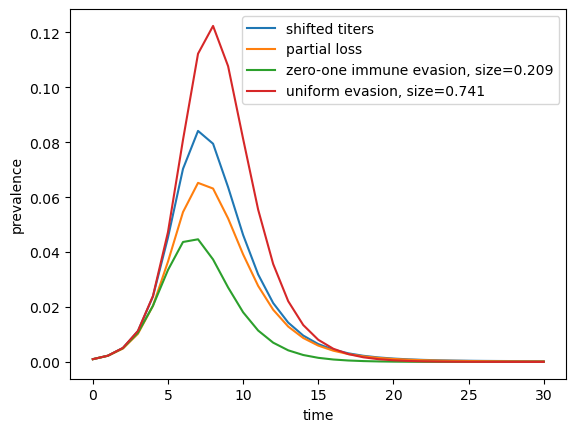

In [66]:
plt.plot(T,sol_shift[:,0], label='shifted titers')
plt.plot(T,sol_loss[:,0], label='partial loss')

S0 = 1/beta
sol_zeroOneEvasion = odeint(SIR, (S0*(1+growth_rate), I), T, args=(beta, gamma))
sol_uniformEvasion = odeint(SIR, (1-I, I), T, args=((1+growth_rate), gamma))

plt.plot(T, sol_zeroOneEvasion[:,1],  
         label=f'zero-one immune evasion, size={S0*(1+growth_rate)-1+final_epidemic_size(beta, S0=S0*(1+alpha)):1.3f}')
plt.plot(T, sol_uniformEvasion[:,1],  
         label=f'uniform evasion, size={final_epidemic_size((1+growth_rate), S0=1):1.3f}')

plt.legend()
plt.xlabel('time')
plt.ylabel('prevalence')


As expected, models with a continuous susceptibility distribution generate wave sizes in between the extreme cases where the entire population is uniformly susceptible, and where a fraction is completely susceptible. The shifted titer-case is closer to the former, the partial loss closer to the latter. 